# Importing Library

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data Preparation

In [2]:
df = pd.read_csv('data.csv')
df.head(n = 3)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


In [5]:
# Formatting column name
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Formatting object type values
strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Exploratory data analysis

In [16]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

year
[2011 2012 2013 1992 1993]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
10

engine_hp
[335. 300. 230. 320. 172.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
71

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16

highway_mpg
[26 28 27 25 24]
59

city_mpg
[19 20 18 17 16]
69

popularity
[3916 3105  819  617 1013]
48

msrp
[46135 40650 36350 29450 345

# Distribution of price

<Axes: xlabel='msrp', ylabel='Count'>

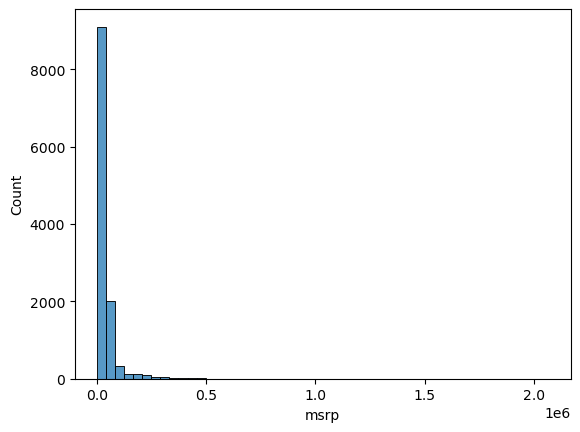

In [17]:
sns.histplot(df.msrp, bins = 50)

<Axes: xlabel='msrp', ylabel='Count'>

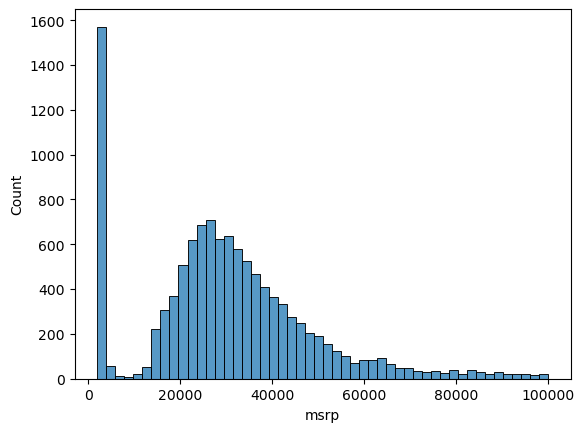

In [18]:
sns.histplot(df.msrp[df.msrp < 100000], bins = 50)

#### There is a long tail in the distribution. It will confuse our ML model. To get rid of the problem, we will use logarithmic distribution.

In [19]:
price_logs = np.log1p(df.msrp)
price_logs

0        10.739349
1        10.612779
2        10.500977
3        10.290483
4        10.448744
           ...    
11909    10.739024
11910    10.945018
11911    10.832122
11912    10.838031
11913    10.274913
Name: msrp, Length: 11914, dtype: float64

<Axes: ylabel='Count'>

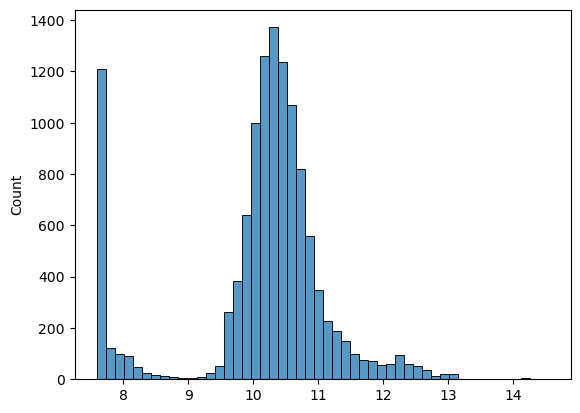

In [20]:
sns.histplot(price_logs.values, bins = 50)

#### This is called the normal distribution. This kind of distribution is ideal for the ML model. In this case of distribution, model performs well.

# Setting Up the Validation framework

In [34]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train]
df_val = df_shuffled.iloc[n_train:n_train + n_val]
df_test = df_shuffled.iloc[n_train + n_val:]

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Linear Regression

In [48]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86]
]
X = np.array(X)
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

In [49]:
def TrainLinearRegression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    w0 = w_full[0]
    w = w_full[1:]
    return w0, w

In [50]:
w0, w = TrainLinearRegression(X, y)
w0, w

(25844.75405576679, array([ -16.08906468, -199.47254894,   -1.22802883]))

# Car price baseline model

In [66]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

In [69]:
df_train[base].isnull().sum()

engine_hp           40
engine_cylinders    14
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [73]:
def prepare_x(df):
    df = df.copy()
    for col in base:
        df[col].fillna(df[col].median(), inplace = True)
    
    X = df[base].values
    return X

In [76]:
X_train = prepare_x(df_train)
w0, w = TrainLinearRegression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
y_pred

array([ 9.52427764,  9.34947071,  9.60391562, ..., 10.32059171,
       11.90854663, 10.00234003])

<Axes: ylabel='Count'>

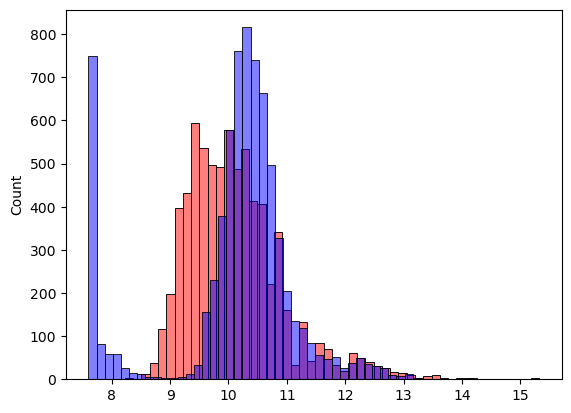

In [77]:
sns.histplot(y_pred, bins = 50, color = 'red', alpha = 0.5)
sns.histplot(y_train, bins = 50, color = 'blue', alpha = 0.5)

# RMSE

In [78]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Validating the model

In [80]:
X_train = prepare_x(df_train)
w0, w = TrainLinearRegression(X_train, y_train)

X_val = prepare_x(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_pred, y_val)

0.7496911329574685

# Simple Feature Engineering

In [108]:
def prepare_x(df):
    df = df.copy()
    features = base.copy()
    
    for col in features:
        df[col].fillna(df[col].median(), inplace = True)
        
    features.append('age')
    df['age'] = df.year.max() - df.year
    
    X = df[features].values
    return X

In [109]:
X_train = prepare_x(df_train)
X_trainX_train = prepare_x(df_train)
w0, w = TrainLinearRegression(X_train, y_train)

X_val = prepare_x(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.507459491281787

<Axes: ylabel='Count'>

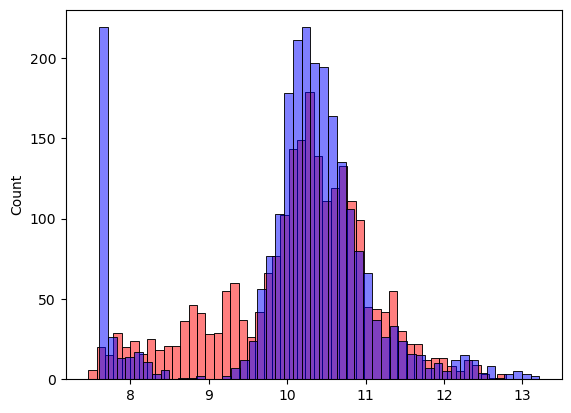

In [100]:
sns.histplot(y_pred, color = 'red', alpha = 0.5, bins = 50)
sns.histplot(y_val, color = 'blue', alpha = 0.5, bins = 50)

# Categorical Variables

In [131]:
def prepare_x(df):
    df = df.copy()
    features = base.copy()
    
    # Handling missing values
    for col in features:
        df[col].fillna(df[col].median(), inplace = True)
        
    valueCount = df['number_of_doors'].value_counts()
    maxValue = valueCount.index[0]
    df['number_of_doors'].fillna(maxValue)
    
    # Adding age as feature   
    features.append('age')
    df['age'] = df.year.max() - df.year
    
    # Adding number_of_doors as feature
    for value in [2., 3., 4.]:
        df[f'number_of_doors_{value}'] = (df.number_of_doors == value).astype('int')
        features.append(f'number_of_doors_{value}')
    
    X = df[features].values
    return X

In [132]:
X_train = prepare_x(df_train)
w0, w = TrainLinearRegression(X_train, y_train)

X_val = prepare_x(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.506362042647631

In [115]:
df_train['number_of_doors'].isnull().sum()

6

# Add more catagorical variable as features

In [133]:
categorical_variables = ['make', 'engine_fuel_type', 'transmission_type',
'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']

categorical_variables

['make',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [139]:
categories = {}
for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head().index)

In [144]:
for c in categorical_variables:
    valueCount = df[c].value_counts()
    print(valueCount[0], valueCount.index[0])

1123 chevrolet
7172 regular_unleaded
8266 automatic
4787 front_wheel_drive
1110 crossover
4764 compact
3048 sedan


In [145]:
def prepare_x(df):
    df = df.copy()
    features = base.copy()
    
    # Handling missing values
    for col in features:
        df[col].fillna(df[col].median(), inplace = True)
        
    valueCount = df['number_of_doors'].value_counts()
    maxValue = valueCount.index[0]
    df['number_of_doors'].fillna(maxValue)
    
    
    for c in categorical_variables:
        valueCount = df[c].value_counts()
        maxValue = valueCount.index[0]
        df[c].fillna(maxValue)
    
    # Adding age as feature   
    features.append('age')
    df['age'] = df.year.max() - df.year
    
    # Adding number_of_doors as feature
    for value in [2., 3., 4.]:
        df[f'number_of_doors_{value}'] = (df.number_of_doors == value).astype('int')
        features.append(f'number_of_doors_{value}')
    
    for cat, values in categories.items():
        for val in values:
            df[f'{cat}_{val}'] = (df[cat] == val).astype('int')
            features.append(f'{cat}_{val}')
    
    X = df[features].values
    return X

In [146]:
X_train = prepare_x(df_train)
w0, w = TrainLinearRegression(X_train, y_train)

X_val = prepare_x(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

63.34305306277777

#### The values of w0 and w and much much bigger. We have added more features to our model to improve RMSE. But it gives a large RMSE. Why did this happen?
#### Sometimes in XTX, there can be duplicate rows. If duplicate rows exist then the inverse matrix does not exist. If exists (these rows are not actually duplicated, just differ for a small value),  the inverse matrix gives a very large or small value. That imbalanced our model prediction more. To get rid of the problem we need regularization. We add a small number with the diagonal element.

# Regularization

#### We add a small amount with diagonal element and get smaller value. The larger the value we add, then we have more control over our result. It does not grow too much

#### Now we can re-implement our TrainLinearRegression(X, y) using regularization

In [147]:
def TrainLinearRegressionReg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    w0 = w_full[0]
    w = w_full[1:]
    
    return w0, w

In [159]:
X_train = prepare_x(df_train)
w0, w = TrainLinearRegressionReg(X_train, y_train)

X_val = prepare_x(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.45513524587302373

# Tuning the model

In [161]:
for r in [1, 10, 20, 0.0, 0.1, 0.01, 0.001, 0.00001, 0.0000001]:
    X_train = prepare_x(df_train)
    w0, w = TrainLinearRegressionReg(X_train, y_train, r)

    X_val = prepare_x(df_val)
    y_pred = w0 + X_val.dot(w)

    error = rmse(y_val, y_pred)
    print(r, w0, error)
    

1 5.537516993322395 0.4558058886293077
10 4.217419548989644 0.46730753565591204
20 3.731770613212091 0.4802996232792599
0.0 4.055308365008181e+16 63.34305306277777
0.1 6.084938978660621 0.4551856612691902
0.01 6.168859347677552 0.4551396244542939
0.001 6.1776056292586 0.45513524587302373
1e-05 4.9147653273003495 0.4551347710499665
1e-07 -13132.429941397702 0.4551362508143005


# Using the model

In [167]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop = True)

y_full_train = np.concatenate([y_train, y_val])

In [169]:
r = 0.001
X_full_train = prepare_x(df_full_train)
w0, w = TrainLinearRegressionReg(X_full_train, y_full_train, r)

X_test = prepare_x(df_test)
y_pred = w0 + X_test.dot(w)

error = rmse(y_test, y_pred)
error

0.45127515428613246

<Axes: ylabel='Count'>

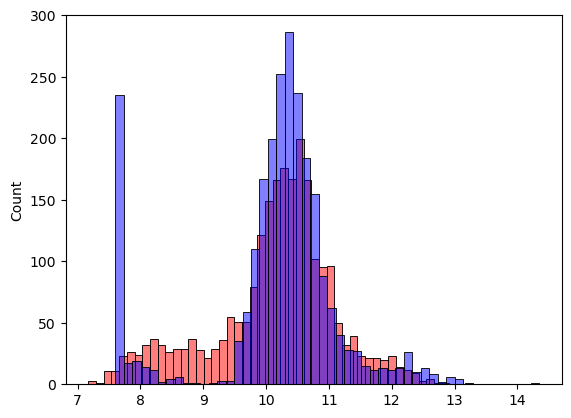

In [170]:
sns.histplot(y_pred, color = 'red', alpha = 0.5, bins = 50)
sns.histplot(y_test, color = 'blue', alpha = 0.5, bins = 50)

### Now let's predict the price of a car

In [179]:
car = df_test.iloc[21].to_dict()
car

{'make': 'dodge',
 'model': 'caravan',
 'year': 2006,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 150.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'flex_fuel',
 'vehicle_size': 'large',
 'vehicle_style': 'passenger_minivan',
 'highway_mpg': 24,
 'city_mpg': 17,
 'popularity': 1851}

In [182]:
df_small = pd.DataFrame([car])
X_small = prepare_x(df_small)
y_pred = w0 + X_small.dot(w)
price = y_pred[0]

print(np.expm1(price), np.expm1(y_test[20]))

29508.66472323623 35000.00000000001


In [175]:
def prepare_x(df):
    df = df.copy()
    features = base.copy()
    
    # Handling missing values
    for col in features:
        df[col].fillna(df[col].median(), inplace = True)
        
    valueCount = df['number_of_doors'].value_counts()
    maxValue = valueCount.index[0]
    df['number_of_doors'].fillna(maxValue, inplace = True)
    
    
    for c in categorical_variables:
        valueCount = df[c].value_counts()
        maxValue = valueCount.index[0]
        df[c].fillna(maxValue)
    
    # Adding age as feature   
    features.append('age')
    df['age'] = df.year.max() - df.year
    
    # Adding number_of_doors as feature
    for value in [2., 3., 4.]:
        df[f'number_of_doors_{value}'] = (df.number_of_doors == value).astype('int')
        features.append(f'number_of_doors_{value}')
    
    for cat, values in categories.items():
        for val in values:
            df[f'{cat}_{val}'] = (df[cat] == val).astype('int')
            features.append(f'{cat}_{val}')
    
    X = df[features].values
    return X